<a href="https://colab.research.google.com/github/yurim-nam/healthlytics/blob/main/EEG_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 2: EEG Depression Analysis



First: Downloading the Data from our dataset

In [ ]:
!wget -O eeg_data.zip "https://reshare.ukdataservice.ac.uk/854301/4/854301_EEG_128Channels_Resting_Lanzhou_2015.zip"
!unzip eeg_data.zip -d eeg_data

--2025-08-26 20:18:19--  https://reshare.ukdataservice.ac.uk/854301/4/854301_EEG_128Channels_Resting_Lanzhou_2015.zip
Resolving reshare.ukdataservice.ac.uk (reshare.ukdataservice.ac.uk)... 155.245.130.19
Connecting to reshare.ukdataservice.ac.uk (reshare.ukdataservice.ac.uk)|155.245.130.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2276623008 (2.1G) [application/zip]
Saving to: ‘eeg_data.zip’

eeg_data.zip        100%[===================>]   2.12G  19.6MB/s    in 1m 52s  

2025-08-26 20:20:13 (19.3 MB/s) - ‘eeg_data.zip’ saved [2276623008/2276623008]

Archive:  eeg_data.zip
   creating: eeg_data/EEG_128channels_resting_lanzhou_2015/
  inflating: eeg_data/EEG_128channels_resting_lanzhou_2015/02010002rest 20150416 1017..mat  
  inflating: eeg_data/EEG_128channels_resting_lanzhou_2015/02010004rest 20150427 1335..mat  
  inflating: eeg_data/EEG_128channels_resting_lanzhou_2015/02010005rest 20150507 0907..mat  
  inflating: eeg_data/EEG_128channels_resting_lan

As we noticed that the EEG files were in .mat (MATLAB) files, we wanted to inspect it before using MNE python.

In [ ]:
import scipy.io as sio # needed to read .mat files

mat = sio.loadmat("/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02010002rest 20150416 1017.mat", squeeze_me=True, struct_as_record=False)
# squeeze_me = True | gets rid of unnecessary singleton dimensions
# struct_as_record= False | Ensures MATLAB structs load as Python objects instead of opaque numpy record arrays.
# makes sure that MATLAB data is easier to navigate through Python.

# Access the MATLAB variable inside
data_struct = mat['a02010002rest_20150416_1017mat']

# If it's a MATLAB struct, extract the field containing the numeric EEG array
# You can check fields with:
print(dir(data_struct))

# Extract numeric EEG array - verifying data integrity
data_array = np.array(data_struct.data)  # shape: (n_electrodes, n_samples)
print("EEG array shape:", data_array.shape) # helps confirm dimensions
print("NaNs:", np.isnan(data_array).sum()) m# checks for missing data
print("Min/Max:", np.min(data_array), np.max(data_array)) # shows amplitude range

# Sampling rate = shows how many data    points per s    econd were recorded.
sfreq = int(mat['samplingRate'])
print("Sampling rate:", sfreq)

['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_namespace__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__buffer__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__'

Building Raw MNE project

We want to do this as we want to use MNE python to work with our data, but in its current state is not compatible with MNE functions. Thus, we're building a Raw object and converting our data in order to use efficiently.

In [ ]:
!pip install mne # installing mne package

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import mne
from mne import create_info
from mne.io import RawArray

In [ ]:
# converts the EEG array to 64-bit floats (float64) for numerical stability in MNE.
data = data_array.astype(np.float64)  # shape (129, n_samples)
n_channels = data.shape[0]

# Create channel names dynamically
ch_names = [f"Ch{i+1}" for i in range(n_channels)] # creates list of names for each electrode
ch_types = ['eeg'] * n_channels # define channel type as EEG

# Create MNE info metadata - includes channel names, sampling frequency, and channel types
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Build Raw object - allows for filtering and analysis using MNE functions
raw = mne.io.RawArray(data, info) # converts numpy EEG array into MNE raw object
print(raw)

Creating RawArray with float64 data, n_channels=129, n_times=75189
    Range : 0 ... 75188 =      0.000 ...   300.752 secs
Ready.
<RawArray | 129 x 75189 (300.8 s), ~74.1 MiB, data loaded>


In [1]:
# helps us restrict to the 128 EEG channels only
raw = mne.io.RawArray(data[:128, :], mne.create_info(
    ch_names=[f"Ch{i+1}" for i in range(128)],
    sfreq=sfreq,
    ch_types=['eeg']*128
))

NameError: name 'mne' is not defined

Preprocessing:

In [3]:
# setting band frequency width for different wave types in EEG
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

Organizing data for separation

In [ ]:
import glob # glob finds file paths matching a pattern

# Path to your folder with MAT files
folder_path = "/content/eeg_data/EEG_128channels_resting_lanzhou_2015/"

# Get list of all MAT files in the folder
all_mat_files = glob.glob(folder_path + "*.mat") # collects all .mat files
print(f"Found {len(all_mat_files)} files")
print(all_mat_files[:5])  # show first 5 files

Found 53 files
['/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02010028rest 20160317 1538..mat', '/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02020025rest 20150713 1519..mat', '/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02030005rest 20151026 2103..mat', '/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02010023rest 20150729 1929..mat', '/content/eeg_data/EEG_128channels_resting_lanzhou_2015/02020020rest 20150703 1754..mat']


In [4]:
# Loading subject metadata - MDD vs HC patient labeling

import os

import pandas as pd

# Load the Excel file
df_labels = pd.read_excel("/content/eeg_data/EEG_128channels_resting_lanzhou_2015/subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx")  # columns: subject_id, type

# Strip spaces from column names
df_labels = df_labels.rename(columns=lambda x: x.strip().replace(" ", "_").lower())

# Ensure IDs are strings and remove any leading apostrophe
df_labels['subject_id'] = df_labels['subject_id'].astype(str).str.lstrip("'")

# Check
print(df_labels.head())

# Convert to dictionary for easy lookup
label_dict = dict(zip(df_labels['subject_id'], df_labels['type']))

# Quick check
# print(label_dict['02010002'])  # should print 'MDD'
print(label_dict['2010002'])  # should print 'MDD'



FileNotFoundError: [Errno 2] No such file or directory: '/content/eeg_data/EEG_128channels_resting_lanzhou_2015/subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx'

In [ ]:
import pandas as pd

features = []
for f in all_mat_files:
    basename = os.path.basename(f)
    subj_id_from_file = basename[:8].lstrip("0")  # match Excel IDs
    group_label = label_dict.get(subj_id_from_file, "Unknown")

    # Load .mat
    mat = sio.loadmat(f, squeeze_me=True, struct_as_record=False)
    eeg_var_name = [k for k in mat.keys() if not k.startswith("__") and k != 'samplingRate'][0]
    data_struct = mat[eeg_var_name]
    data_array = np.array(data_struct.data)  # (128, n_samples)
    sfreq = int(mat['samplingRate'])

    # Create MNE RawArray
    ch_names = [f"E{i+1}" for i in range(data_array.shape[0])]
    ch_types = ['eeg'] * data_array.shape[0]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(data_array, info)
    raw.filter(1, 45, fir_design='firwin', verbose=False)

    # Compute PSD
    psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024, method='welch', average='mean')
    psds = psd.get_data()
    freqs = psd.freqs

    # Compute bandpower per channel
    band_powers = {}
    for band_name, (fmin, fmax) in bands.items():
        idx = (freqs >= fmin) & (freqs <= fmax)
        band_powers[band_name] = psds[:, idx].mean(axis=1)

    # Build feature vector
    row = {"subject": subj_id_from_file, "group": group_label}
    for band_name, values in band_powers.items():
        for ch_idx, val in enumerate(values):
            row[f"E{ch_idx+1}_{band_name}"] = val
    features.append(row)

# Convert to DataFrame
df_features = pd.DataFrame(features)
print(df_features.shape)
print(df_features.head())

analysis

In [ ]:
# Features (all columns except 'subject' and 'group')
X = df_features.drop(columns=["subject", "group"]).values

# Labels
y = df_features["group"].values

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X, y)

# Get feature importances
importances = clf.feature_importances_

In [ ]:
n_channels = 128
band_importances = {}

# For each band, sum importance across all channels
for i, band_name in enumerate(bands.keys()):
    # indices for this band in the flattened feature array
    band_idx = list(range(i, n_channels*len(bands), len(bands)))
    band_importances[band_name] = importances[band_idx].sum()

print("Feature importance by frequency band:")
print(band_importances)

Feature importance by frequency band:
{'delta': np.float64(0.18117544749111347), 'theta': np.float64(0.2314559368901976), 'alpha': np.float64(0.18483533423394627), 'beta': np.float64(0.18004454039817142), 'gamma': np.float64(0.21600477359249137)}


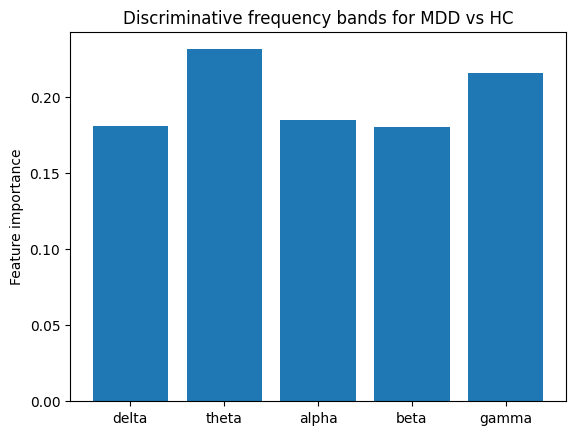

In [ ]:
import matplotlib.pyplot as plt

plt.bar(band_importances.keys(), band_importances.values())
plt.ylabel("Feature importance")
plt.title("Discriminative frequency bands for MDD vs HC")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split features/labels
X = df_features.drop(columns=["subject", "group"])
y = df_features["group"].map({"HC": 0, "MDD": 1})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train, y_train)

# Baseline accuracy
y_pred = clf.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, y_pred))

# Get real importances
real_importances = clf.feature_importances_

# Collapse importances by frequency band (ignore electrode index)
band_means_real = {}
for col, imp in zip(X.columns, real_importances):
    band = col.split("_")[-1]   # e.g. "delta", "theta", etc.
    band_means_real[band] = band_means_real.get(band, 0) + imp

# Permutation test
n_perms = 1000
band_means_null = {band: [] for band in band_means_real.keys()}

for i in range(n_perms):
    y_perm = np.random.permutation(y)  # shuffle labels
    clf_perm = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    clf_perm.fit(X_train, np.random.permutation(y_train))  # shuffle training labels

    perm_importances = clf_perm.feature_importances_
    band_sums = {}
    for col, imp in zip(X.columns, perm_importances):
        band = col.split("_")[-1]
        band_sums[band] = band_sums.get(band, 0) + imp

    for band in band_means_null.keys():
        band_means_null[band].append(band_sums.get(band, 0))

    null_importances = {band: [] for band in bands}

# Compute p-values
p_values = {}
for band in band_means_real.keys():
    null_dist = np.array(band_means_null[band])
    real_val = band_means_real[band]
    p_val = (np.sum(null_dist >= real_val) + 1) / (n_perms + 1)  # one-sided
    p_values[band] = p_val

print("Real band importances:", band_means_real)
print("Permutation p-values:", p_values)

Baseline accuracy: 0.7272727272727273
Real band importances: {'delta': np.float64(0.1702078867827746), 'theta': np.float64(0.18301312983376652), 'alpha': np.float64(0.14561652676963951), 'beta': np.float64(0.20613916837548615), 'gamma': np.float64(0.29502328823833357)}
Permutation p-values: {'delta': np.float64(0.7692307692307693), 'theta': np.float64(0.5084915084915085), 'alpha': np.float64(0.7002997002997003), 'beta': np.float64(0.3646353646353646), 'gamma': np.float64(0.08091908091908091)}


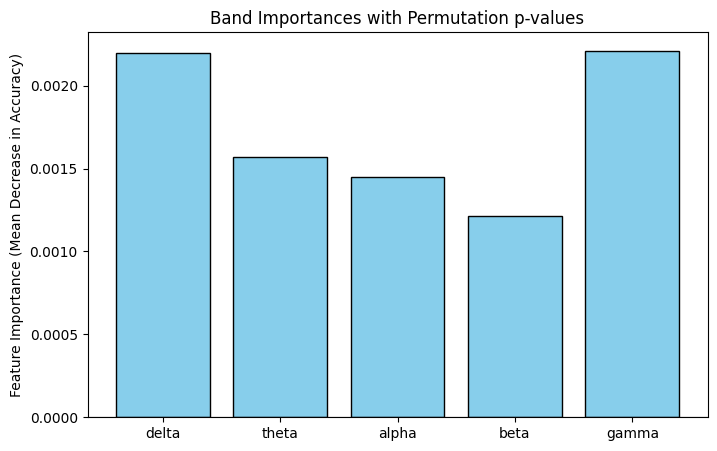

In [ ]:
import matplotlib.pyplot as plt

# If real_importances is an array, rebuild it into a dict:
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

if not isinstance(real_importances, dict):
    real_importances = {band: float(val) for band, val in zip(bands, real_importances)}

if not isinstance(p_values, dict):
    p_values = {band: float(val) for band, val in zip(bands, p_values)}


# --- Plot real importances ---
plt.figure(figsize=(8, 5))
bands = list(real_importances.keys())
real_vals = [real_importances[b] for b in bands]
pvals = [p_values[b] for b in bands]

bars = plt.bar(bands, real_vals, color="skyblue", edgecolor="black")
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Feature Importance (Mean Decrease in Accuracy)")
plt.title("Band Importances with Permutation p-values")

plt.show()

In [ ]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X, y)
baseline_acc = accuracy_score(y, model.predict(X))
real_importances = dict(zip(bands, model.feature_importances_))

n_permutations = 1000
null_importances = {band: [] for band in bands}

for i in range(n_permutations):
    # Shuffle labels
    y_perm = np.random.permutation(y)
    model.fit(X, y_perm)

    # Store permutation importances
    importances_perm = model.feature_importances_
    for j, band in enumerate(bands):
        null_importances[band].append(importances_perm[j])

# Convert to arrays
for band in bands:
    null_importances[band] = np.array(null_importances[band])

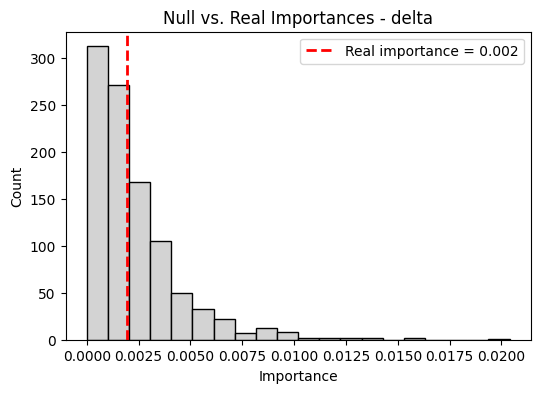

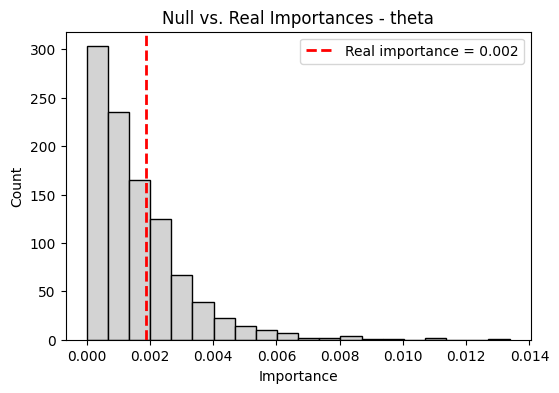

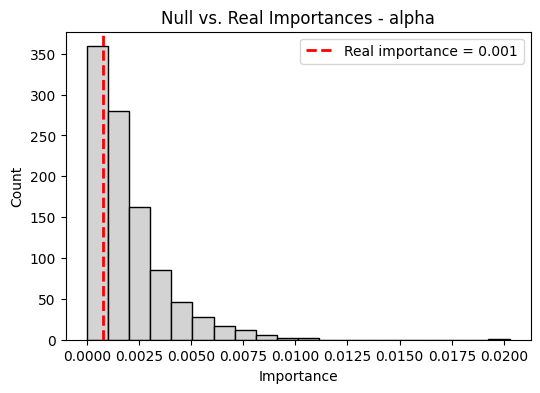

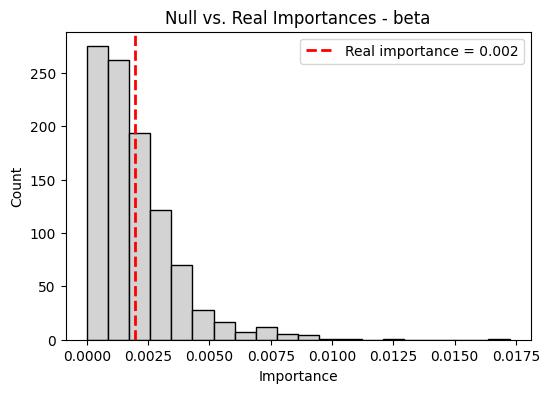

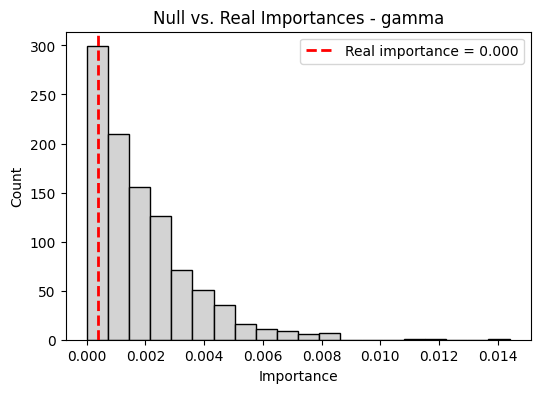

In [ ]:
# Loop through each frequency band
for band in bands:
    plt.figure(figsize=(6,4))

    # Histogram of null importances for this band
    plt.hist(null_importances[band], bins=20, color="lightgray", edgecolor="black")

    # Add vertical line for the real importance
    plt.axvline(real_importances[band], color="red", linestyle="--", linewidth=2,
                label=f"Real importance = {real_importances[band]:.3f}")

    # Title and labels
    plt.title(f"Null vs. Real Importances - {band}")
    plt.xlabel("Importance")
    plt.ylabel("Count")
    plt.legend()
    plt.show()